In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [3]:
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)
sfh = sfh_all.query('year == 2004')
dogs = pd.read_csv('data/akc.csv').dropna()

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


In [19]:
should_clear = ['bingroup']

def clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def clear_props(traces):
    for trace in traces:
        for prop in should_clear:
            clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

(ch:viz_scale)=
# Choosing Scale to Reveal Structure


Take a look at the following histogram of house prices.

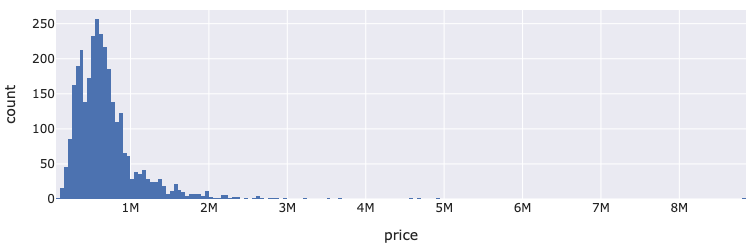

In [5]:
px.histogram(sfh, x='price', width=350, height=250)

Is this plot accurate? Yes---it displays all the data.
But most of the data are crammed into the left side of the plot, which makes it
hard to use the plot to understand house prices.

Though data visualization, we want to reveal important facts about the data
like the shape of a distribution and the relationship between features. 
As this example shows, after we produce an initial plot there are still
other principles we need to consider.
In this section, we cover **principles of scale** which help us decide how to
adjust the axis limits, place tick marks, and apply transformations.


## Filling the Data Region

As we can see from the above plot of house prices, it's hard to read
a distribution when
most of the data appear in a small portion of the plotting region.
When this happens, we can't clearly see important facts about the data like
whether there are multiple modes or skewness.
A similar issue happens for scatter plots. 
When all the points are bunched together in a scatter plot, it's hard to
see nonlinearity.

This issue most often happens when there are 
a few unusually large observations.
In order to get a better view of the main portion
of the data we can drop these observations from the plot by adjusting the
x- or y-axis limits, or by removing outlier values from the data before
plotting.
In either case, we must mention this exclusion in
the caption or on the plot itself.

**Example: San Francisco Housing Price Distribution.**
Let's improve the plot of housing prices. In the plot below, we've put the
default histogram on the left. On the right, we've excluded houses that cost
over \$200,000 by adjusting the x-axis limits. 
The shape of the distribution for the bulk of the houses is much clearer in 
this plot.
For instance, we can more easily observe the skewness of the main mode.

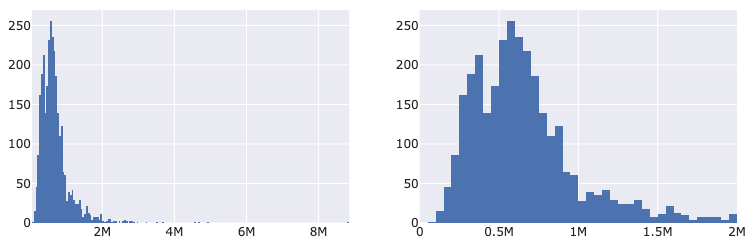

In [6]:
left = px.histogram(sfh, x='price')
right = px.histogram(sfh, x='price')

fig = left_right(left, right, height=250)
fig.update_xaxes(range=[0, 2e6], row=1, col=2)

We can also show detail in the long right tail of this distribution with
a separate plot, displayed below.

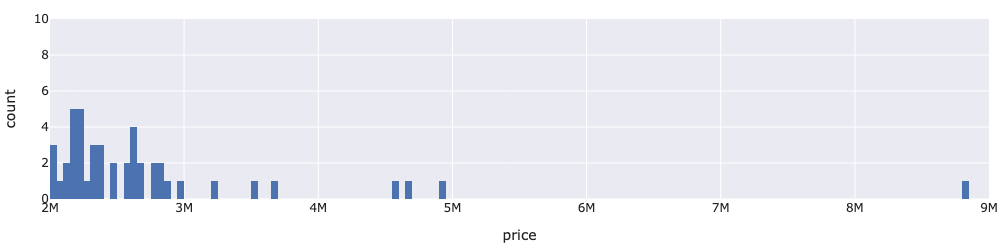

In [99]:
fig = px.histogram(sfh, x='price', width=350, height=250)
fig.update_xaxes(range=[2e6, 9e6])
fig.update_yaxes(range=[0, 10])

In this example, we addressed the issue of scale in the original plot of 
housing prices by making two plots, one for the bulk of the data and one for
the tail.
By choosing useful x- and y-axis limits for both plots, we can show more
useful information about the distribution.

**Including Zero.**
We often don't need to include 0 on an axis, especially
if including it makes it difficult to fill the data region.
For instance, the scatter plot below shows the average longevity plotted
against average height for dog breeds. The x-axis starts at 10 cm since
all dogs are taller than that.

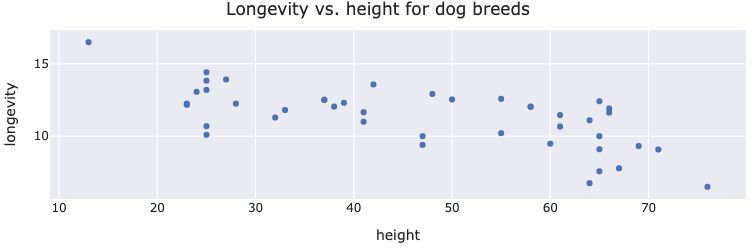

In [102]:
fig = px.scatter(dogs, x='height', y='longevity',
                 title='Longevity vs. height for dog breeds',
                 width=350, height=250)
margin(fig, t=30)

There are a few cases where we usually want to include 0.
For bar charts, including 0 is important.
We've created two bar charts below. The left plot includes 0, but the right
plot doesn't. It's easy to incorrectly conclude from the right
plot that medium-sized dogs live twice as long as large-sized dogs.

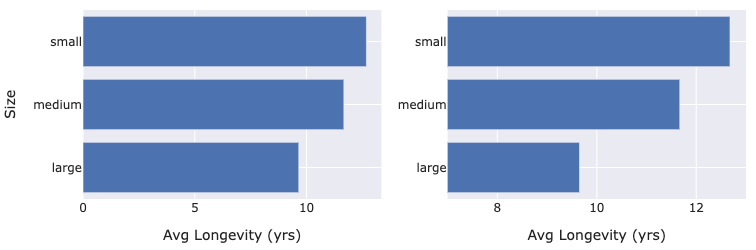

In [20]:
dogs_lon = dogs.groupby('size')['longevity'].mean().reset_index()
sml = {"size": ['small', 'medium', 'large']}
left = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)
right = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)

fig = left_right(left, right, height=250)
fig.update_xaxes(range=[7, 13], row=1, col=2)
fig.update_xaxes(title_text='Avg Longevity (yrs)')
fig.update_layout(yaxis_title="Size")

We also typically want to include zero when working with proportions, since
proportions range from 0 to 1.
The plot below shows the proportion of dogs of each dog group in our dataset.

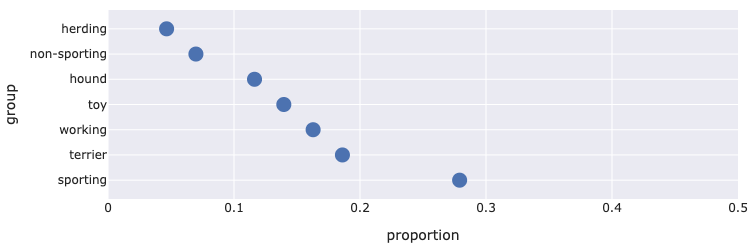

In [21]:
size_props = ((dogs['group'].value_counts() / len(dogs))
              .reset_index()
              .rename(columns={'index': 'group', 'group': 'proportion'}))

size_props
fig = px.scatter(size_props, x='proportion', y='group', category_orders=sml,
                 width=350, height=250)
fig.update_traces(marker_size=15)
fig.update_xaxes(range=[0, 0.5])

**Banking to Decipher Relationships.** With scatterplots, we try to choose a
scale so that the relationship between the two features roughly follows a
45-degree line. This is called "banking to 45 degrees", and makes it
easier for the reader to see shape and trends.
That is, it is much easier for us to
determine departures from a line when the data roughly fall along a 45-degree
line within the plotting region.
For instance, we've reproduced the plot that
shows longevity of dog breeds against height.
The plot has been banked to 45 degrees, and we can more easily
see where the data deviate.

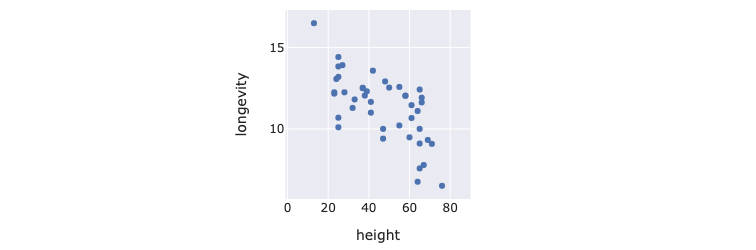

In [160]:
fig = px.scatter(dogs, x='height', y='longevity', width=250, height=250)

fig.update_xaxes(
    constrain="domain",
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=8,
)
fig

## Revealing Shape Through Transformations

Another common way to adjust scale is to transform the data or the plot axes. 
We use transformations most often for highly skewed data
since sometimes the transformation produces a symmetric distribution, which
is easier to inspect and is more useful in later modeling steps.

There are multiple ways to transform data, but the log-transform
is especially useful.
For instance, we've reproduced two histograms of SF house prices below.
The left histogram is the original data.
On the right, we've taken the log (base 10) of the original prices
before plotting.

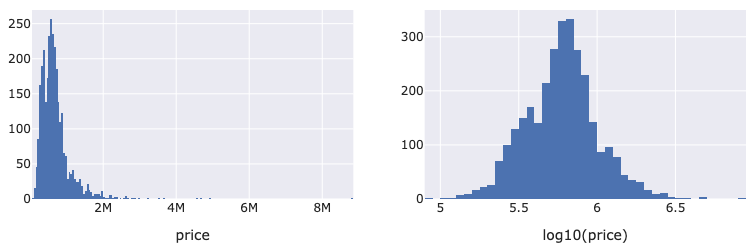

In [25]:
sfl = sfh.assign(log_price=np.log10(sfh['price']))

orig = px.histogram(sfl, x='price', width=350, height=250)
logged = px.histogram(sfl, x='log_price',
                      nbins=100,
                      labels=dict(log_price='log10(price)'),
                      width=350, height=250)

fig = left_right(orig, logged)
fig.update_xaxes(title_text='price', row=1, col=1)
fig.update_xaxes(title_text='log10(price)', row=1, col=2)

The log transformation makes the distribution of prices more symmetric.
We can more easily see important features of the distribution, like
the mode at around 10^5.8 ≈ $700,000. With some calculation,
we also see that most house prices lie between \$300,000 and \$2,000,000.

The downside of using the log transform is that the actual values aren't
immediately usable---in this example, we needed to convert the values back to
original dollars. Because of this, we often favor transforming the axis to
use a log scale. When we do this, we don't transform the data. Instead,
we set the axis scale when we plot the code.

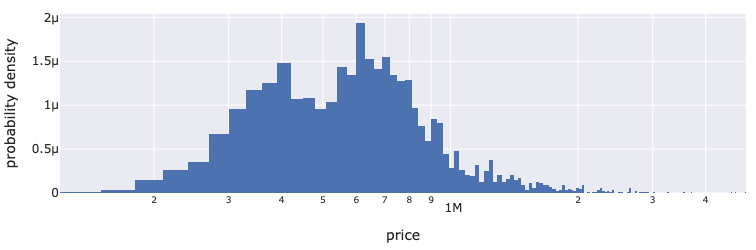

In [220]:
fig = px.histogram(sfh, x='price',
                   log_x=True,
                   histnorm='probability density',
                   width=350, height=250)
fig.update_traces(xbins_size=30_000)

The above histogram with log scaled x-axis shows a similar result to 
directly transforming the data.
But since the axis is displayed using original units, we can directly
read off its values.

The log transform can also reveal shape for two dimensional plots.
In the scatter plot below, we've put the building size on the x-axis and
the lot size on the y-axis.
It's hard to see the shape in this plot since many of the points are crammed
into the bottom.

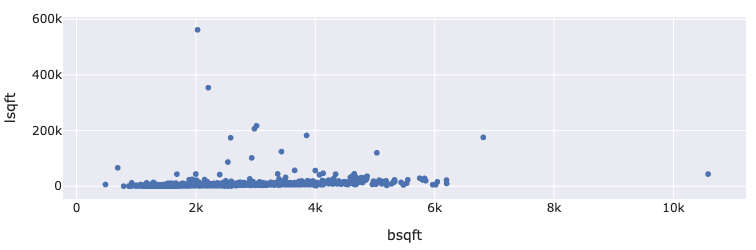

In [260]:
px.scatter(sfh, x='bsqft', y='lsqft',
           width=350, height=250)

But if we use a log scale for both x- and y-axes, the shape is much
easier to see:

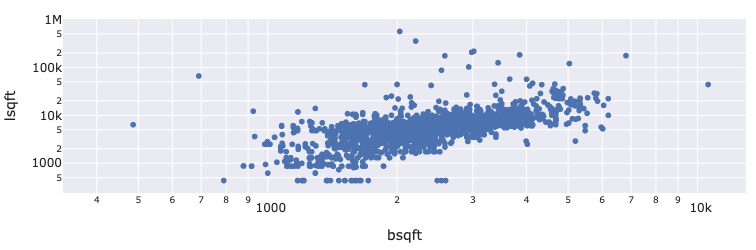

In [261]:
px.scatter(sfh, x='bsqft', y='lsqft',
           log_x=True, log_y=True,
           width=350, height=250)

With the transformed axes, we can see that the lot size increases rapidly
as building size increases---a typical 1000 ft² building
has a lot size of about 1500 ft², but a typical 5000 ft² building has a lot
size of about 15,000 ft².

**Revealing Relationships Through Straightening.**
We use scatter plots to look at the relationship between two variables.
For instance, in the plot below we've plotted heights against weights
for our dogs dataset.
We see that taller dogs weigh more, but this relationship isn't linear.

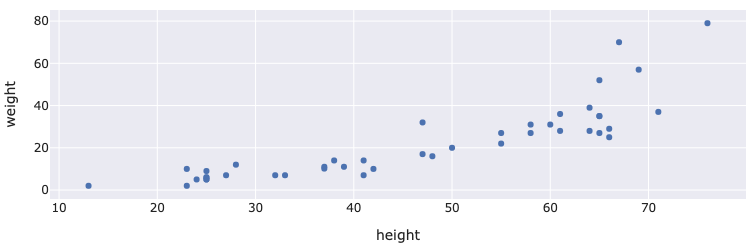

In [223]:
px.scatter(dogs, x='height', y='weight',
           width=350, height=250)

When it looks like two variables have a non-linear relationship, it's useful
to try applying a log scale the x-axis, y-axis, or both.
We look for a linear relationship in the scatter plot with transformed axes.
For instance, we applied a log scale to both x- and y-axes in the plot below.

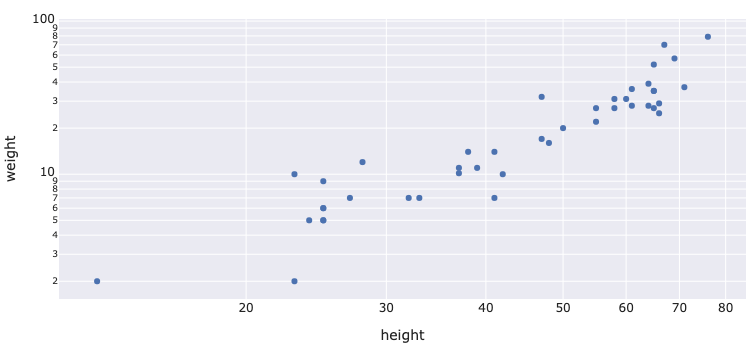

In [250]:
px.scatter(dogs, x='height', y='weight',
           log_x=True, log_y=True,
           width=350, height=350)

When we see a linear relationship after transforming axes, we can use
{numref}`Table %s <tab:transform-rels>` to see what relationship the original
variables have.
The derivations of these relationships requires a bit of algebra, which
we leave as an exercise to the reader.

:::{table} Relationships between two variables when transformations are applied. $a$ and $b$ are constants.
:name: tab:transform-rels

| x-axis       | y-axis       | Relationship              |
| ------------ | ------------ | ------------------------- |
| No transform | No transform | Linear: $ y = ax + b $    |
| Log-scale    | No transform | Log: $ y = a \log x + b $ |
| No transform | Log-scale    | Exponential: $ y = ba^x $ |
| Log-scale    | Log-scale    | Polynomial: $ y = bx^a $  |

:::

In this case, since we observe a roughly linear relationship when both
axes are on a log scale, we can say that there's a polynomial relationship
between dog height and weight.
This makes sense intuitively---if a dog is taller, it's probably both longer
and wider. So we might expect that the weight of a dog has a cubic
relationship with its height.

As {numref}`Table %s <tab:transform-rels>` shows, 
the log transform can reveal several common types of relationships.
Because of this, the log transform is considered the jackknife of 
transformations.
As another, albeit
artificial, example, the leftmost plot in
{numref}`Figure %s <example-transforms>`
reveals a curvilinear
relationship between x and y. The middle plot show a different curvilinear
relationship between log(y) and x; this plot also appears nonlinear. A
further log transformation, at the far right in the figure, displays a plot of
log(y) against log(x). This plot confirms that the data have a log-log
relationship because the transformed points fall along a line.

```{figure} figures/example-transforms.png
---
name: example-transforms
---

These scatter plots show how log transforms can "straighten" a curvilinear
relationship between two variables.
```

## Takeaways

Adjusting scale is an important practice in data visualization.
In this section, we adjusted the limits of x- and y-axes to fill the data 
region.
We also saw how applying a log transformation to the plot axes can help
reveal shape, especially for non-linear relationships between two variables.
In the next section, we'll look at principles of smoothing which we use 
when we need to visualize lots of data at once.